# Which UK town feels the most earthquakes?

> The short answer is Manchester tied with Fort William.  To see the top 20, skip on to [the results section](#Top-20-UK-towns-for-earthquake-activity).  Otherwise, read on to learn about Pandas, GeoPandas and how you can do GIS with Python without needing a desktop GIS software (e.g. QGIS, ESRI ArcMap).

This [Jupyter notebook](http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html#notebook-document) demonstrates how the GeoPandas library can be used to perform GIS analysis using just Python code.  In this case, we calculate the UK town that feels the most earthquakes.  It is a simple example using real-world data from the British Geological Survey's [earthquake catalogue](http://earthquakes.bgs.ac.uk/earthquakes/dataSearch.html).  To run this for yourself and experiment with changing variables, follow with instructions in the [README.md](README.md) file.

The notebook has three parts:

1. Introduction to [Pandas](https://pandas.pydata.org/).
2. Introduction to [GeoPandas](http://geopandas.org/).
3. Example analysis.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import os
from shapely.geometry import Point, Polygon
%matplotlib inline

# 1. Introduction to Pandas

Pandas adds _dataframe_ structures to Python and has been central to the rise of Python in the field of data science.  This section shows some the features of Pandas for handling tables of data.

In [2]:
# View the structure of the input data
! head uk_earthquakes.csv

yyyy-mm-dd, hh:mm:ss.ss, lat, lon, depth, ML, Nsta, RMS, intensity, locality
1703-12-28, 17:03:00.0, 53.620, -0.110, , 4.2, , , 5-6 ," HULL "
1726-10-26, 07:00:00.0, 50.660, -2.470, , 3.3, , , 5 ," DORCHESTER "
1727-07-19, 04:00:00.0, 51.570, -3.760, 25.0, 5.2, , , 7 ," SWANSEA "
1728-03-01, 04:30:00.0, 55.580, -2.810, 21.0, 4.2, , , 4 ," GALASHIELS "
1734-10-25, 03:50:00.0, 50.200, -0.700, 14.0, 4.5, , , 5 ," PORTSMOUTH "
1736-04-30, 11:00:00.0, 56.170, -3.690, , 2.7, , , 6 ," OCHIL HILLS "
1744-02-05, 00:00:00.0, 52.950, -3.510, , 2.9, , , 5 ," MERIONETH "
1747-07-01, 22:30:00.0, 50.960, -3.110, , 3.5, , , 5 ," TAUNTON "
1749-02-14, 08:30:00.0, 55.420, -3.770, , 2.7, , , 5-6 ," LEADHILLS "


## Load data

In [3]:
# Load into Pandas dataframe, specifying that two columns represent date and time
earthquakes = pd.read_csv('uk_earthquakes.csv',
    skipinitialspace=True,
    usecols=['yyyy-mm-dd', 'hh:mm:ss.ss', 'lat', 'lon', 'depth', 'ML', 'locality'],
    parse_dates=[['yyyy-mm-dd', 'hh:mm:ss.ss']], infer_datetime_format=True)

# Fix datetime column name and typo in locality name
earthquakes.rename(columns={'yyyy-mm-dd_hh:mm:ss.ss': 'datetime'}, inplace=True)
earthquakes.set_index('datetime', inplace=True)

# Check data within data frame
earthquakes.head()

,lat,lon,depth,ML,locality
datetime,,,,,
1703-12-28 17:03:00,53.62,-0.11,NaN,4.2,HULL
1726-10-26 07:00:00,50.66,-2.47,NaN,3.3,DORCHESTER
1727-07-19 04:00:00,51.57,-3.76,25.0,5.2,SWANSEA
1728-03-01 04:30:00,55.58,-2.81,21.0,4.2,GALASHIELS
1734-10-25 03:50:00,50.20,-0.70,14.0,4.5,PORTSMOUTH


## Explore the data

The following analysis uses plain Pandas, without real geospatial analysis.

#### Range of magnitudes

`describe` function gives summary statistics on columns

In [4]:
print(earthquakes[['ML', 'depth', 'lat']].describe())

                 ML        depth           lat
count  10638.000000  9365.000000  10916.000000
mean       1.281303     6.765884     54.968459
std        0.938884     6.116607      2.831757
min       -1.900000     0.000000     49.009000
25%        0.700000     2.100000     53.040000
50%        1.200000     5.100000     55.507500
75%        1.800000     9.300000     56.240000
max        6.100000    42.300000     63.000000


`hist` function plots histograms

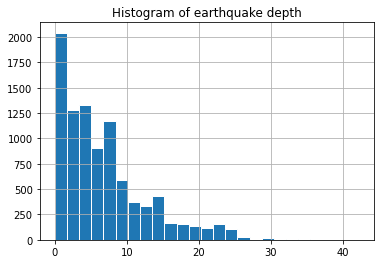

In [5]:
ax = earthquakes['depth'].hist(bins=25, edgecolor='white')
txt = ax.set_title('Histogram of earthquake depth')

All of the earthquakes are less than 30 km deep, which is about the thickness of the Earth's crust.  Shallower rocks are more brittle and more likely to produce earthquakes.

#### Ten largest quakes since 1700

`sort_values` sorts values.  The clue is in the name.

In [6]:
earthquakes.sort_values('ML', ascending=False).head(10)

,lat,lon,depth,ML,locality
datetime,,,,,
1931-06-07 00:25:00.000,54.08,1.50,23.0,6.1,NORTH SEA
1938-06-11 10:57:00.000,50.78,3.58,NaN,5.8,BELGIUM
1927-01-24 05:18:00.000,59.68,2.70,25.0,5.7,NORTH SEA
1977-04-06 19:32:04.000,61.50,3.00,NaN,5.6,NORTH SEA
1926-07-30 13:19:00.000,49.17,-1.62,18.0,5.5,CHANNEL ISLANDS
1984-07-19 06:56:13.600,52.96,-4.38,20.7,5.4,"LLEYN PENIN,NW WALES"
1927-02-17 23:17:00.000,49.17,-1.62,22.0,5.4,CHANNEL ISLANDS
1896-12-17 05:32:00.000,52.02,-2.55,20.0,5.3,HEREFORD
1852-11-09 04:25:00.000,53.02,-4.30,24.0,5.3,CAERNARVON


The UK is not a very seismically active area.  These earthquakes are certainly large enough to be felt and to cause damage, but across the whole planet there are at least [1,000 earthquakes of this size each year](https://earthquake.usgs.gov/earthquakes/browse/stats.php).  The British Geological Survey has a page on [Earthquake magnitude calculations](http://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/magnitudeScaleCalculations.html).

#### Variation in rate of earthquakes with time

Pandas has excellent time-series processing capabilities.  The `resample` function groups data into annual bins.

The number of earthquakes measured each year doesn't just depend on how often they occur; it also depends on how well they can be detected.

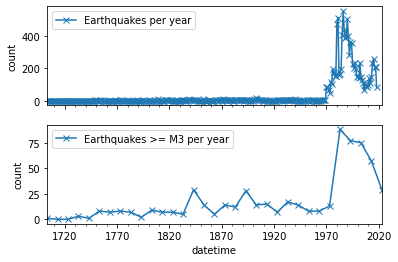

In [7]:
quakes_per_year = earthquakes.resample('1Y').size()
big_quakes_per_year = earthquakes[earthquakes['ML'] >= 3].resample('10Y').size()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
quakes_per_year.plot(ax=ax1, label='Earthquakes per year', marker='x')
ax1.legend()
ax1.set_ylabel('count')
big_quakes_per_year.plot(ax=ax2, label='Earthquakes >= M3 per year', marker='x')
ax2.legend()
txt = ax2.set_ylabel('count')

The big rise in recorded earthquakes around 1970 reflects the establishment a modern seismic monitoring network.  Older earthquake data come from isolated seismometers or have been inferred from reports of shaking and damage.

#### Plot x, y data

The `plot.scatter` function is good for x,y data.  In this case, there is no awareness that the data are spatial.  Depth vs Magnitude can be plotted in the same way as Longitude vs Latitude.

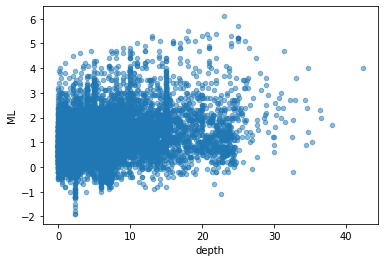

In [8]:
ax = earthquakes.plot.scatter('depth', 'ML', alpha=0.5)

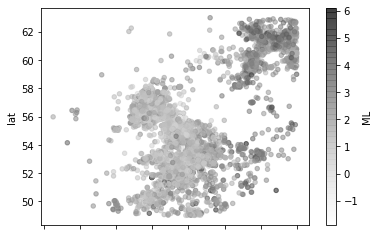

In [9]:
ax = earthquakes.plot.scatter('lon', 'lat', c='ML', alpha=0.5)

## 2. Introduction to Geopandas

GeoPandas extends Pandas to allow spatial operations on geometry objects.  It uses the same spatial libraries as other open source GIS tools e.g. QGIS and PostGIS, so the results are the same as the analysis had been done in desktop GIS.  Common GIS tasks are shown here.

### Load UK regions from GIS file

Geopandas uses [Fiona](http://toblerity.github.io/fiona), which in turn uses [GDAL/OGR](http://gdal.org), which means that it can read and write
most GIS formats.  Here, data are read from a [GeoPackage](http://geopackage.org) file.  These are the new standard in open-source GIS and contain multiple layers.

First load UK administrative regions and populated places based on [NaturalEarth](http://www.naturalearthdata.com) data. This is a public domain dataset of physical and political GIS data.  It is useful for adding context to maps.  The attribute tables are accessible as Pandas-style dataframes.

In [10]:
# Load data form GIS file
regions = gpd.read_file('./data/ne_10m_uk.gpkg', layer='admin_1_states_provinces')
towns = gpd.read_file('./data/ne_10m_uk.gpkg', layer='populated_places')

# View attribute data for first 5 rows
regions.head()

,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,name_local,type,...,sub_code,gns_level,gns_lang,gns_adm1,gns_region,min_label,max_label,min_zoom,orig_ogc_fid,geometry
0,GBR-2001,2001,GB-EAY,None,GB,1,East Ayrshire,None,None,Unitary District,...,None,1,ind,None,UK35,10.0,11.0,10.0,1209,"MULTIPOLYGON (((-4.25369 55.68554, -4.25098 55..."
1,GBR-2002,2002,GB-EDU,None,GB,1,East Dunbartonshire,None,None,Unitary District,...,None,1,ind,None,UK35,10.0,11.0,10.0,1210,"MULTIPOLYGON (((-4.13253 56.00413, -4.12574 56..."
2,GBR-2003,2003,GB-ERW,None,GB,1,East Renfrewshire,None,None,Unitary District,...,None,1,ind,None,UK35,10.0,11.0,10.0,1211,"MULTIPOLYGON (((-4.33787 55.79293, -4.31999 55..."
3,GBR-2004,2004,GB-GLG,None,GB,1,Glasgow,Glasgow City,None,Unitary District (city),...,None,1,ind,None,UK35,10.0,11.0,10.0,1212,"MULTIPOLYGON (((-4.19051 55.88871, -4.17475 55..."
4,GBR-2005,2005,GB-IVC,None,GB,1,Inverclyde,None,None,Unitary District,...,None,1,eng,None,UK01,10.0,11.0,10.0,1213,"MULTIPOLYGON (((-4.62683 55.92975, -4.62679 55..."


Spatial data are stored in the `geometry` column.

In [11]:
regions.geometry.head()

0    MULTIPOLYGON (((-4.25369 55.68554, -4.25098 55...
1    MULTIPOLYGON (((-4.13253 56.00413, -4.12574 56...
2    MULTIPOLYGON (((-4.33787 55.79293, -4.31999 55...
3    MULTIPOLYGON (((-4.19051 55.88871, -4.17475 55...
4    MULTIPOLYGON (((-4.62683 55.92975, -4.62679 55...
Name: geometry, dtype: geometry

The `plot` function plots the map.  Features can be coloured based on column data.

Text(-13, 58, 'Rockall')

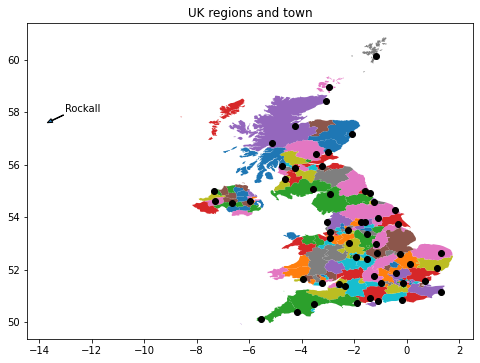

In [12]:
ax = regions.plot(figsize=(8, 8), column='name')
towns.plot(ax=ax, color='black')
txt = ax.set_title('UK regions and town')

# Draw arrow to highlight Rockall, which is too small to
# have been drawn on the map (see next section).
plt.annotate('Rockall', xy=(-13.687, 57.596), xytext=(-13, 58),
             arrowprops=dict(width=0.5, headwidth=4, headlength=5))

## Note that you can easily save plots to file in a variety of formats e.g.
# plt.savefig('map.pdf')
# plt.savefig('map.png', dpi=300)

### Perform geometric operations e.g. intersections

The map above is shifted to the east because of the tiny island of [Rockall](https://en.wikipedia.org/wiki/Rockall).  We can trim this off using the `intersection` method.

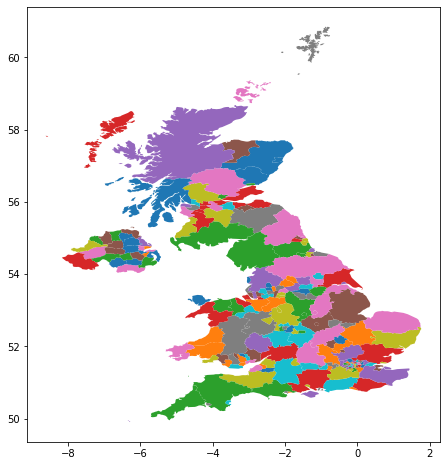

In [13]:
area_of_interest = Polygon([(-9, 49), (-9, 62), (2, 62), (2, 49)])
regions['geometry'] = regions.intersection(area_of_interest)
ax = regions.plot(figsize=(8, 8), column='name')

### Perform spatial operations based on attribute data

We can select individual polygons based on their attributes, then manipulate their geometries.  Vector data can be `dissolved`, which is the spatial equivalent of `group_by`.  The _geonunit_ attribute column contains country name.  Here we combine all region polygons belonging to the same country into a single polygon.

geonunit
England             POINT (-1.45867 52.59503)
Northern Ireland    POINT (-6.69366 54.60866)
Scotland            POINT (-4.17031 56.82896)
Wales               POINT (-3.75695 52.33927)
dtype: geometry


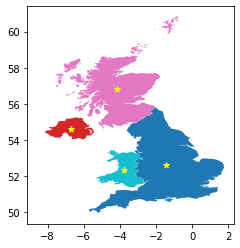

In [14]:
countries = regions[['geonunit', 'geometry']].dissolve(by='geonunit')
countries['country'] = countries.index.values
ax = countries.plot(column='country')

# GeoDataframes have extra attributes based on their geometry
# e.g. centroids
print(countries.centroid)
countries.centroid.plot(ax=ax, marker='*', color='yellow')

### Re-project data to Ordnance Survey coordinate system

Coordinate reference systems can be specified using [EPSG codes](http://spatialreference.org/ref/epsg/).  `epsg:4326` is longitude and latitude as returned by GPS systems (using WGS84 datum).  `epsg:27700` is the Ordnance Survey for Great Britain.  GeoPandas provides the `to_crs` method to set this.

In [15]:
countries_osgb = countries.to_crs('EPSG:27700')
towns_osgb = towns.to_crs('EPSG:27700')

Working in projected coordinates allows spatial calculations e.g. compare areas of countries of the UK in square kilometres...

In [16]:
1e-6 * countries_osgb.area

geonunit
England             130372.965283
Northern Ireland     14273.430342
Scotland             78288.149877
Wales                20787.610403
dtype: float64

... or in the UK media's favourite measure of area comparison, the _sizeofwales_.

In [17]:
countries_osgb.area / countries_osgb.loc['Wales', 'geometry'].area

geonunit
England             6.271667
Northern Ireland    0.686632
Scotland            3.766097
Wales               1.000000
dtype: float64

### Export to file

`to_file` writes data to any vector file format supported by OGR.  Which is most of them.  Here we write our new `countries` dataframe as a Shapefile.

In [18]:
output_file_name = os.path.join('data', 'countries.shp')
countries.to_file(output_file_name)

## 3. Example analysis

Here we find the most earthquake-prone town in the UK (or, to be precise, the regionally-important UK town with most earthquakes with magnitude > 3 within a 40 km radius since 1970).

### Convert existing DataFrame into GeoDataFrame

To do spatial operations, it is necessary to convert the `lon` and `lat` columns of our earthquakes dataframe into geometry objects.  GeoPandas uses the [Shapely](https://github.com/Toblerity/Shapely) library for this.  Our coordinates will become a `Point`.  We also have to set the coordinate reference system.

In [19]:
# Add geometry and convert to spatial dataframe in source CRS
earthquakes['coords'] = list(zip(earthquakes['lon'], earthquakes['lat']))
earthquakes['coords'] = earthquakes['coords'].apply(Point)
earthquakes = gpd.GeoDataFrame(earthquakes, geometry='coords', crs='EPSG:4326')

# Reproject data in to Ordnance Survey GB coordinates
earthquakes_osgb = earthquakes.to_crs('EPSG:27700')

Earlier we saw that the earthquake catalogue was only complete from 1970 onwards so we only want records from then onwards.  We also take only earthquakes above magnitude 3 as these are the most likely to be felt.

In [20]:
# Extract larger quakes from when monitoring network was established
big_quakes_osgb = earthquakes_osgb[(earthquakes_osgb['ML'] >= 3)]['1970-01-01':]

### Plot earthquakes against UK outline

Data can now be plotted against the reference maps loaded from the Geopackage file. The largest earthquakes since 1970 have been highlighted on this map.

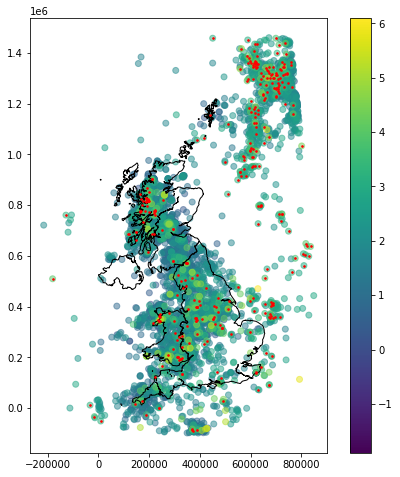

In [21]:
# Create the axis first
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all earthquakes
earthquakes_osgb.sort_values('ML', ascending=True).plot(
    ax=ax, column='ML', legend=True, alpha=0.5)
# Add country outlines
countries_osgb.plot(ax=ax, edgecolor='black', facecolor='none')

# Highlight the biggest earthquakes
big_quakes_osgb.plot(
    ax=ax, color='red', marker='.', markersize=10)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')

The earthquakes are not evenly spread.  They are mainly associated with recent movement on ancient faults.  Many are in the North Sea.  The crust there was stretched during the Jurassic-Triassic period and produced the basins where oil-bearing rocks are found today.  Earthquakes in the NW Highlands of Scotland are near the Great Glen Fault and Moine Thrust fault lines.  These were formed during even older continental collisions.

### Find earthquakes within 40 km of towns

It is reasonable that a magnitude 3 earthquake will be felt 40 km away.  We can define 40 km circles around each town using the `buffer` function.

In [22]:
towns_buffer = towns_osgb[['NAME', 'geometry']].copy()
towns_buffer['geometry'] = towns_osgb.buffer(40000)

To find which earthquakes could be felt in each town, we do a [spatial join](http://geopandas.org/mergingdata.html#spatial-joins).

In [23]:
# Note that spatial joins requires rtree python package and libspatialindex-c4v5 Debian/Ubuntu package
quakes_by_town = gpd.sjoin(big_quakes_osgb, towns_buffer, op='within', how='left')
quakes_by_town.dropna(subset=['NAME'], inplace=True)

Plotting the earthquakes coloured by the `NAME` of the towns that they are close to shows which ones fall within the buffers around the towns.

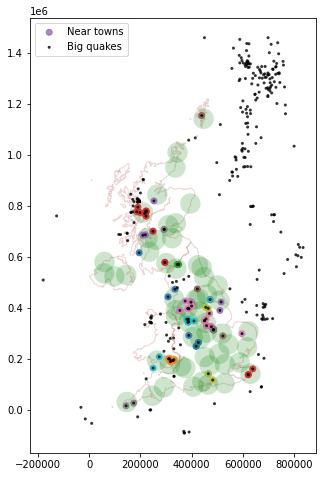

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
countries_osgb.plot(ax=ax, edgecolor='brown', facecolor='none', alpha=0.2)
towns_buffer.plot(ax=ax, color='green', alpha=0.2)
quakes_by_town.plot(ax=ax, column='NAME', figsize=(12, 12), alpha=0.8, label='Near towns')
big_quakes_osgb.plot(ax=ax, color='black', edgecolor='none', alpha=0.8, marker='.',
                     label='Big quakes')
ax.set_aspect('equal', 'box')
leg = ax.legend()

### Top 20 UK towns for earthquake activity

The map above shows which earthquakes are close to towns.  Applying the Pandas `value_counts` function to the quakes by town shows the Top 20.

And the winner is: a draw!  Fort William ties with Manchester with 9 earthquakes each within a 40 km radius with magnitude greater than 3.

In [25]:
quakes_by_town['NAME'].value_counts().head(20)

Fort William          9
Manchester            9
Cardiff               7
Sheffield             7
Stoke                 7
Nottingham            6
Leicester             5
Carlisle              4
Peterborough          4
Greenock              3
Dover                 3
Kingston upon Hull    3
Birmingham            3
Bradford              2
Dumfries              2
Leeds                 2
Coventry              2
Bristol               2
Blackpool             2
Perth                 2
Name: NAME, dtype: int64

### Conclusion

This is a very simplistic analysis, but it demonstrates how easily such workflows can be carried out using Python.  Reading, analysis and plotting take very few lines of code, and the code is self-documenting, which is important for transparency and reproducibility.

It is also very easy to repeat and adjust the analysis.  For example, 1970 to the present is a very short time period.  It is probably not representative of longer term patterns.  As an exercise, try running the notebook again using all earthquakes since 1700.  The results may surprise you!  See [here](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1365-3121.1993.tb00288.x) for explanation.

## 4. Notes

#### Geospatial analysis as a web service

Automated analyses can be incorporated into a functions.  The example below
lists earthquakes within a certain radius of a given point.  This could be configured to return output in JSON format output and wrapped in a Python web framework such as [Falcon](http://falconframework.org).  The result would be a geospatial web service that performs automatic GIS-type analysis in response to HTTP requests.

In [26]:
def get_nearby_earthquakes(lon, lat, radius=20000):
    """
    Return records from the earthquake catalogue within a given 
    distance of a point location.
    
    :param lon: Longitude in decimal degrees
    :param lat: Latitude in decimal degress
    :param buffer: Search radius in metres
    :return quakes: Pipe-separated representation of earthquake data
    """
    # Create dataframe with buffered point
    osgb = pyproj.Proj('EPSG:27700')
    x, y = osgb(lon, lat)
    search_zone = gpd.GeoDataFrame(geometry=[Point(x, y).buffer(radius)],
                                   crs='EPSG:27700')
    
    # Do spatial join
    quakes = gpd.sjoin(big_quakes_osgb, search_zone, how='inner')
    
    # Tidy output
    quakes.index.name = 'timestamp'
    quakes.reset_index(inplace=True)
    quakes = quakes[['timestamp', 'lat', 'lon', 'depth', 'ML', 'locality']]
    
    return quakes.to_csv(index=False, sep='|', float_format='%.4f')

In [27]:
# The coordinates are for BGS HQ in Keyworth
result = get_nearby_earthquakes(-1.089, 52.871)
print(result)

timestamp|lat|lon|depth|ML|locality
1984-05-30 02:53:59.400|52.8710|-1.1250|17.8000|3.0000| NOTTINGHAM 
2001-10-28 16:25:24.900|52.8350|-0.8490|14.4000|4.1000| MELTON MOWBRAY,LEICS 



#### Data cleaning

The CSV file downloaded from the website needed the following tweaks before it was ready for use:

+ Add quotes around _locality_ field `cat raw.csv | sed 's/,/,"/9;s/$/"/' > uk_earthquakes.csv`
+ Manually remove space from _locality_ field name
+ Manually remove data before 1700 because Pandas can't parse those timestamps automatically
+ Manually fix typo in timestamp (1971-11-21, 07:68:36.2)

#### Acknowledgements

This notebook was inspired by Joris Van den Bossche's [geopandas-tutorial](https://github.com/jorisvandenbossche/geopandas-tutorial), which he gave at the [GeoPython 2018](http://2018.geopython.net/) conference.